## Machine Learning Project: Japanese Vowel speaker classification

### Importing data into time series arrays 

In [1]:
import numpy as np
import pandas as pd
import copy

In [2]:
# importing data sets
trainData = np.loadtxt("ae.train")
testData = np.loadtxt("ae.test")

#### Overview: 
* Training: 270 (30 utterances by 9 speakers. See file 'size_ae.train'.) 
* Testing: 370 (24-88 utterances by the same 9 speakers in different opportunities. See file 'size_ae.test'.) 

In [3]:
# obtaining 270 training time series arrays
# arrays are (N x 12); where N is length of time series recording and 12 is number of dimensions (ie channels)
trainInputs = np.empty((270,1), dtype=object)
readindex = 0

for i in range(1,271):
    readindex = readindex + 1  
    l = 0
    while trainData[readindex-1, 1] != 1:
        l = l + 1 
        readindex = readindex + 1
    trainInputs[i-1,0] = trainData[readindex-l-1:readindex-1,:]


# obtaining 370 test time series arrays 
# arrays are (N x 12); where N is length of time series recording and 12 is number of dimensions (ie channels)
testInputs = np.empty((370,1), dtype=object)
readindex = 0

# The last 12 entries of each recording are 1s, indicating 12 channels
# They are droppped when reading in the data
for i in range(1,371):
    readindex = readindex + 1
    l = 0 
    while testData[readindex-1, 1] != 1:
        l = l+1 
        readindex = readindex + 1
    testInputs[i-1,0] = testData[readindex-l-1:readindex-1,:] 

In [4]:
# obtaining 270 training outputs (speaker targets)
# arrays are (N x 9); where N is length of time series recording and 9 is number of different speakers
# the speaker is indicated with a '1'
trainOutputs = np.empty((270,1), dtype=object)

for i in range(1,271):
    l = np.size(trainInputs[i-1,0],0)
    teacher = np.zeros((l,9))
    speakerIndex = np.ceil(i/30)
    teacher[:,np.int(speakerIndex)-1] = 1 
    trainOutputs[i-1,0] = teacher

# obtaining 370 test outputs (speaker targets)
# arrays are (N x 9); where N is length of time series recording and 9 is number of different speakers
# the speaker is indicated with a '1'
testOutputs = np.empty((370,1), dtype=object)
speakerIndex = 1
blockCounter = 0
blockLengthes = [31, 35, 88, 44, 29, 24, 40, 50, 29]
for i in range(1, 371):
    blockCounter = blockCounter + 1 
    if blockCounter == blockLengthes[speakerIndex-1] + 1:
        speakerIndex = speakerIndex + 1
        blockCounter = 1
    l = np.size(testInputs[i-1,0], 0)
    teacher = np.zeros((l,9))
    teacher[:,np.int(speakerIndex)-1] = 1   
    testOutputs[i-1, 0] = teacher

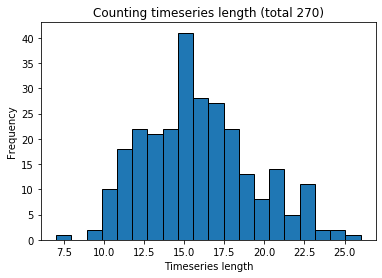

In [5]:
# Prints histogram of timeseries length (exploratory analysis)
import matplotlib.pyplot as plt

histos = np.zeros(270)

for i in range(270):
    histos[i] = (len(trainInputs[i, 0]))

#print(histos)
plt.title('Counting timeseries length (total 270)')
plt.xlabel('Timeseries length')
plt.ylabel('Frequency')
plt.hist(histos, bins = 20, ec='black')
plt.show()

### Add length of each recording as a feature

In [6]:
RecordingLength = histos

for i in range(270):
    RecordingLength[i] = RecordingLength[i] / 26
#print(RecordingLength)

for i in range(270):
    lenArray = len(trainInputs[i][0])
    rec = np.full(lenArray, RecordingLength[i])
    newArray = np.column_stack((trainInputs[i][0][:], rec))
    trainInputs[i][0] = newArray

### Data Preprocessing: Polynomial approximation

In [58]:
# Flattening the input and doing POSTpadding -------
# Easier to adapt in the poly approx code ----------
# --------------------------------------------------

size_max = 13 * 26
Resample = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputs:
    element = np.ndarray.flatten(element[0])
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array
    Resample[idx] = element
    idx = idx + 1

# Reshaping the input -------------------------------
# ---------------------------------------------------
Resample = Resample.reshape(270, 26, 13)

# Replace padded zeros with polynomial approximations
#----------------------------------------------------

from scipy.interpolate import interp1d
from scipy import interpolate

def interpol(xValues, yValues, x):
    cs = interpolate.splrep(xValues, yValues, k = 3)
    return interpolate.splev(x, cs)

for i in range(270):
    for j in range(13):
        if j == 12:
            for m in range(26):
                Resample[i][m][12] = Resample[i][0][12]
        else:
            recordingLength = round(Resample[i][0][12])
            paddingLength = 26 - recordingLength
            yValues = np.zeros(recordingLength)
            xValues = np.zeros(recordingLength)
            zValues = np.zeros(26)

            for k in range(recordingLength):
                xValues[k] = k + 1
                yValues[k] = Resample[i][k][j]
            for l in range(26):
                zValues[l] = 1 + l * ((recordingLength - 1)/25)
            #print(recordingLength)
            #print(xValues)
            #print("yValues: ")
            #print(yValues)
            #print(zValues)
            predictedValues = interpol(xValues, yValues, zValues)
            #print("predictValues: ")
            #print(predictedValues)
            for m in range(26):
                Resample[i][m][j] = predictedValues[m]
            
#print(Resample[0])


[[1.8609360000000001 -0.20738300000000004 0.26155700000000004
  -0.21456200000000003 -0.17125300000000004 -0.11816700000000001
  -0.2775570000000001 0.025668000000000003 0.12670100000000004
  -0.30675600000000003 -0.21307600000000002 0.08872800000000002 20.0]
 [1.8612997384809338 -0.18267564860375698 0.23066032694827415
  -0.23210975711229836 -0.13138649129094818 -0.11807963739773934
  -0.29651289668834213 -0.03313024304488419 0.16759635054539174
  -0.28624022660364096 -0.24664031615731866 0.09767908741566142 20.0]
 [1.9502480607158543 -0.22399147883240778 0.25213937058999186
  -0.28359093449549977 -0.07174701811840963 -0.10070745726830832
  -0.35094318924536183 0.000719325107547616 0.17187577823353656
  -0.3031130564842153 -0.24041328231675593 0.080195845212439 20.0]
 [1.8842704517550042 -0.2351111337998948 0.251752034317442
  -0.27795948556258804 -0.029785404169083842 -0.11171942802410294
  -0.396248012895325 0.016582010824505528 0.16950054042774218
  -0.31793195814043296 -0.22070957

In [1]:
# Normalise Resampling sample
#---------------------------

# Find Minimum value of each channel for each sample
for i in range(270):
    for j in range(12):
        for k in range(26):
            

### Data Preprocessing: Subtract minimum value of channel from each value. Finish with padding

In [ ]:
#according to the paper by Dwarampudi et al 2019(in whatsappchat), prepadding is preferred. 
#However we seem to get better results with postpadding. That's why both are kept for the moment.

In [ ]:
#First: Find minimum of all channels of all samples
minimum = np.zeros(13)
for sample in trainInputs:
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            if number < minimum[channelnumber]:
                minimum[channelnumber] = number
            channelnumber = channelnumber + 1   

In [ ]:
print(minimum)

In [ ]:
#Subtract minimum value from all values per channel
trainInputsNonNegative = copy.deepcopy(trainInputs)
samplenumber = 0
for sample in trainInputsNonNegative:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsNonNegative[samplenumber][0][arraynumber][channelnumber] = number - minimum[channelnumber]
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1

In [ ]:
# Pads the training inputs with zeroes to make all the timeseries of equal length
size_max = 13 * 26
trainInputsNonNegativePre = np.empty((270,size_max), dtype=object)
trainInputsNonNegativePost = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputsNonNegative:
    element = np.ndarray.flatten(element[0])
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsNonNegativePre[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (12 * 26 = 312)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array
    # print(element)

    trainInputsNonNegativePost[idx] = element
    idx = idx + 1

trainOutputsNew = np.empty((270,1), dtype=object)

# Transforms the trainOutputs in classes 1-9
idxx = 0
for elements in trainOutputs:
    for i in range(len(elements[0][0])):
       if elements[0][0][i] == 1:
           trainOutputsNew[idxx] = i + 1
           idxx = idxx + 1
        
trainOutputsNew = np.ravel(trainOutputsNew)
trainOutputsNew = trainOutputsNew.astype('int')


### Data Preprocessing 2: Put numbers in range 0-1. Finish with padding

In [ ]:
#Additionally set numbers between 0/1
#Find maximum per channel
trainInputsZeroOne = copy.deepcopy(trainInputsNonNegative)
maximum = np.zeros(13)
for sample in trainInputsNonNegative:
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            if number > maximum[channelnumber]:
                maximum[channelnumber] = number
            channelnumber = channelnumber + 1

#divide by maximum value per channel
samplenumber = 0
for sample in trainInputsZeroOne:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsZeroOne[samplenumber][0][arraynumber][channelnumber] = number / maximum[channelnumber]
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1

#pad the samples
size_max = 13 * 26
trainInputsZeroOnePre = np.empty((270,size_max), dtype=object)
trainInputsZeroOnePost = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputsZeroOne:
    element = np.ndarray.flatten(element[0])
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsZeroOnePre[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (13 * 26 = 338)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array

    trainInputsZeroOnePost[idx] = element
    idx = idx + 1

### Interpolation of the Data using a cubic polynomial
#### (in other words: approximating the data with a simple 1D polynomial)

In [ ]:
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.interpolate import CubicSpline

#trainInputsZeroOnePre

def interpol(xValues, yValues, x):
    cs = interpolate.splrep(xValues, yValues)
    return interpolate.splev(x, cs)

samplingFactor = 1
sizePoly = 26 * samplingFactor

inputReshaped = trainInputsZeroOnePre.reshape(270, 26, 13)
polyAugment = np.zeros((270, sizePoly, 13))
NoPaddingButResampling = inputReshaped

for i in range(270):
    for j in range(13):
        if j == 12:
            num = NoPaddingButResampling[i][25][12]
            for m in range(26):
                NoPaddingButResampling[i][m][12] = num

            # code below doesn't work (commented out)
            # recordingLength is from the previous iteration and you're actually not assigning anything

            #finalInput = np.zeros(samplingFactor * recordingLength)
            #for m in range (samplingFactor * recordingLength):
                #finalInput[m] = inputReshaped[i][25][12]

        recordingLength = round(inputReshaped[i][25][12] * 26)
        paddingLength = 26 - recordingLength
        yValues = np.zeros(recordingLength)
        xValues = np.zeros(recordingLength)

        for idx in range(recordingLength):
            xValues[idx] = idx

        for k in range(26):
            if k >= paddingLength:
                yValues[k - paddingLength] = inputReshaped[i][k][j]
        
        zValues = np.zeros(samplingFactor * recordingLength * 3)
        for idx in range(1, samplingFactor * recordingLength * 3):
            zValues[idx] = zValues[idx - 1] + (1 / samplingFactor)
     
        augmentedArray = interpol(xValues, yValues, zValues)

        for s in range(paddingLength):
            NoPaddingButResampling[i][s][j] = augmentedArray[s]

        for idx in range(samplingFactor * recordingLength):
            polyAugment[i][idx + samplingFactor * paddingLength][j] = augmentedArray[idx]
        

#print(polyAugment)
#print(NoPaddingButResampling)


### Data Preprocessing 3: Induce bias by squaring. Finish with padding

In [ ]:
#Normalize/Bias numbers by squaring
trainInputsSquared = copy.deepcopy(trainInputsZeroOne)

#divide by maximum value per channel
samplenumber = 0
for sample in trainInputsSquared:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsSquared[samplenumber][0][arraynumber][channelnumber] = number *number
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1

#pad normalized further samples
size_max = 13 * 26
trainInputsSquaredPre = np.empty((270,size_max), dtype=object)
trainInputsSquaredPost = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputsSquared:
    element = np.ndarray.flatten(element[0])
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsSquaredPre[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (13 * 26 = 338)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array

    trainInputsSquaredPost[idx] = element
    idx = idx + 1

In [ ]:
# Crossvalidation. Currently only splitting in train-test data. Ideally, we want a validation set as well (e.g. 80 - 10 - 10 or 60 - 20 - 20)
# Function taken from my Intro to Data Science assignment 3 code
from sklearn.model_selection import train_test_split

def splitData(inputs, outputs):   
    # To avoid overfitting, we divide the dataset into a part for training and a part for testing
    # We split the dataset into 80% training data and 20% testing data
    inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(
            inputs, outputs, test_size=0.20) 
    
    return inputs_train, inputs_test, outputs_train, outputs_test

inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputsNonNegative, trainOutputsNew)

print('Length inputs_train:', len(inputs_train))
print('Length outputs_train:', len(outputs_train))
print('Length inputs_test:', len(trainOutputsNew))
print('Length trainOutputsNew:', len(trainOutputsNew))


In [ ]:
from sklearn import svm

# Implementation Support Vector Machine
def SVM(inputs_train, outputs_train, inputs_test):    
    # Create a classifier 
    classifier = svm.SVC(kernel='linear')    
    outputs_train = outputs_train.astype('int')
    classifier.fit(inputs_train, outputs_train)
    
    # Predict the test data
    labels_prediction = classifier.predict(inputs_test)

    return labels_prediction

def predictLabels(trainInputs, trainOutputs):
    inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputs, trainOutputs)

    # Predict the test labels
    prediction = SVM(inputs_train, outputs_train, inputs_test)

    # Print results
    wrong = 0
    length = len(prediction)
    for i in range(length):
        #print(prediction[i], np.ravel(outputs_test)[i])
        if(prediction[i] != np.ravel(outputs_test)[i]):
            wrong = wrong + 1

    return ((length - wrong) / length) * 100

#Pre is for prepadded, Post for postpadded
accuracy_NonNegativePre = np.zeros(10)
accuracy_NonNegativePost = np.zeros(10)
accuracy_ZeroOnePre = np.zeros(10)
accuracy_ZeroOnePost = np.zeros(10)
accuracy_SquaredPre = np.zeros(10)
accuracy_SquaredPost = np.zeros(10)
for j in range(10):
    accuracy_NonNegativePre[j] = predictLabels(trainInputsNonNegativePre, trainOutputsNew)
    accuracy_NonNegativePost[j] = predictLabels(trainInputsNonNegativePost, trainOutputsNew)
    accuracy_ZeroOnePre[j] = predictLabels(trainInputsZeroOnePre, trainOutputsNew)
    accuracy_ZeroOnePost[j] = predictLabels(trainInputsZeroOnePost, trainOutputsNew)
    accuracy_SquaredPre[j] = predictLabels(trainInputsSquaredPre, trainOutputsNew)
    accuracy_SquaredPost[j] = predictLabels(trainInputsSquaredPost, trainOutputsNew)
    
print("Average accuracy NonNegativePre:", np.mean(accuracy_NonNegativePre))
print("Average accuracy NonNegativePost:", np.mean(accuracy_NonNegativePost))
print("Average accuracy ZeroOnePre:", np.mean(accuracy_ZeroOnePre))
print("Average accuracy ZeroOnePost:", np.mean(accuracy_ZeroOnePost))
print("Average accuracy SquaredPre:", np.mean(accuracy_SquaredPre))
print("Average accuracy SquaredPost:", np.mean(accuracy_SquaredPost))



In [ ]:
# Perform preprocessing: PCA
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Try: all data in one vector
trainInputsList = [trainInputsNonNegativePre, trainInputsNonNegativePost, trainInputsZeroOnePre, trainInputsZeroOnePost, trainInputsSquaredPre, trainInputsSquaredPost]
Outputs = np.reshape(trainOutputsNew, (270,1))
for PCAInputs in trainInputsList:
    #print(Outputs)
    allTrainInputs = np.concatenate([PCAInputs,Outputs],axis=1)
    
    datasetPCA = pd.DataFrame(allTrainInputs)
    
    pca = PCA(n_components=5)
    pca.fit(datasetPCA)
    principalComponents = pca.fit_transform(datasetPCA)

    print(pca.explained_variance_ratio_)

In [ ]:

# I used the following code to optimise the parameters of SOM:
#from sklearn.model_selection import RandomizedSearchCV


#param_grid = {
    #"n_rows": [5, 10, 20, 40, 60, 80, 100],
    #"n_columns": [5, 20, 40, 40, 60, 80, 100],
    #"learning_rate_start": [0.3, 0.5, 0.7, 0.9],
    #"learning_rate_end": [0.1, 0.05, 0.005],
#}

#som = susi.SOMRegressor()
#clf = RandomizedSearchCV(som, param_grid, random_state=1)
#clf.fit(trainInputsSquaredPost, trainOutputsNew)
#print(clf.best_params_)

In [ ]:
# Results for the best parameters:
# {'n_rows': 40, 'n_columns': 40, 'learning_rate_start': 0.7, 'learning_rate_end': 0.005}

In [ ]:
# Data Reduction with Self-organising maps (SOM)
# pip3 install susi
import sys
sys.path.append('/Users/lauridsstockert/opt/anaconda3/lib/python3.7/site-packages')

import susi

som = susi.SOMClustering(n_rows=40, n_columns = 40, learning_rate_start=0.7, learning_rate_end=0.005)

inputs_train_som = som.fit_transform(trainInputsSquaredPost)
inputs_train_som2 = som.fit_transform(trainInputsSquaredPre)

In [ ]:
# Accuracy is generally around 50-60% It should be expected that it is lower than before, because no sophisticated algorithm has been applied (only SVM)
accuracy_input_squared_padded_after = np.zeros(100)
accuracy_input_squared_padded_before = np.zeros(100)
for i in range(100):
    accuracy_input_squared_padded_after[i] = predictLabels(inputs_train_som, trainOutputsNew)
    accuracy_input_squared_padded_before[i] = predictLabels(inputs_train_som2, trainOutputsNew)
print("Av. Accuracy (padding after, squared, and normalised)", np.mean(accuracy_input_squared_padded_after))
print("Av. Accuracy (padding before, squared, and normalised)", np.mean(accuracy_input_squared_padded_before))

## Data reduction & visualisation with UMAP

In [ ]:
# Data Reduction with UMAP
# pip3 install umap-learn
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sys

# Installing didn't work on my machine, so I provided tha path manually
sys.path.append('/Users/lauridsstockert/opt/anaconda3/lib/python3.7/site-packages')

import umap

sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

In [ ]:
def umapCalc(input_data, n_neighbors, n_components, min_dist):
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components = n_components, min_dist = min_dist)
    embedding = reducer.fit_transform(input_data)
    return embedding

def drawUmap(input_data, input_labels, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(input_data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=input_labels)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=input_labels)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=input_labels, s=100)
    if n_components > 3:
        print("ERROR: Cannot draw more than 3 dimensions")
    plt.title(title, fontsize=18)

In [ ]:
# Trying Data Reduction with UMAP
# Results range can get as high as 77% (best try so far)
# I have commented out the code for parameter optimisation

#accuracy_padded_after = np.zeros(100)
######accuracy_padded_before = np.zeros(100)
#cnt = 1

#for n in (2, 5, 10, 20):
    #for d in (0.1, 0.2, 0.4):
        #for c in (2, 5):
            #accuracy_padded_after = np.zeros(100)
            #inputs_train_umap = umapCalc(trainInputsSquaredPost, n, c, d)
            #for i in range(100):
                #accuracy_padded_after[i] = predictLabels(inputs_train_umap, trainOutputsNew)
            #print("Params are n_neighbors(n), min_dist(d), and n_components(c) \n  n = {}, d = {}, c = {}".format(n, d, c))
            #print("Av. Accuracy (padding after)", np.mean(accuracy_padded_after))
            #print("\n")
            #cnt = cnt + 1
# empirically good combinations:
# Acc = 77%: n = 50, d = 0.99, c = 7
# Acc = 63.37%: n = 20, d = 0.8, c = 2

In [ ]:
for n in (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12):
    drawUmap(input_data = trainInputsSquaredPost, input_labels = trainOutputsNew, n_neighbors=n, n_components = 3, title='n_neighbors = {}'.format(n))

In [ ]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    drawUmap(input_data = trainInputsSquaredPost, input_labels = trainOutputsNew, min_dist=d, title='min_dist = {}'.format(d))


In [ ]:
pca = PCA(n_components=2)
pca.fit(trainInputsNonNegativePre)

# Prints PCA plot (Does only work with a PCA with 2 components)
# Code based on https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
principalComponents = pca.fit_transform(trainInputsNonNegativePre)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, pd.DataFrame(Outputs)], axis = 1)
#print(finalDf)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
# Choose the speakers that you want to visualize in the plot
targets = [1, 3, 4]
colors = 'r', 'g', 'b'
# Uncomment if you want to visualize all speakers
#targets = [1,2,3,4,5,6,7,8,9]
#colors = ['r', 'g', 'b', 'k', 'c', 'm', 'y', 'tab:orange', 'tab:brown']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()

### LSTM classifier implementation

In [ ]:
#for those packages install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional
from keras.layers import Activation
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.preprocessing import sequence
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
def predictLabelsLSTM(trainInputs, trainOutputs):
    inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputs, trainOutputs)
    
    inputs_train = np.asarray(inputs_train).astype('float32')
    inputs_test = np.asarray(inputs_test).astype('float32')
    outputs_train = np.asarray(outputs_train).astype('float32')
    outputs_test = np.asarray(outputs_test).astype('float32')
    #choose embedding length that is equal to the amount of dimensions
    #embedding_vecor_length = 13
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = inputs_train[0])))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(units = 100)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])
    #print(model.summary())
    #[print(i.shape, i.dtype) for i in model.inputs]
    #[print(o.shape, o.dtype) for o in model.outputs]
    #[print(l.name, l.input_shape, l.dtype) for l in model.layers]
    
    model.fit(inputs_train, outputs_train, epochs=17, batch_size=4)
    
    scores = model.evaluate(inputs_test, outputs_test, verbose=0)

    return scores[1]*100

#Pre is for prepadded, Post for postpadded
accuracy_NonNegativePre = np.zeros(1)
accuracy_NonNegativePost = np.zeros(1)


#--------------
accuracy_ZeroOnePre = np.zeros(1)
#--------------
accuracy_PolyAugment = np.zeros(1)

accuracy_NoPaddingButResampling = np.zeros(1)



accuracy_ZeroOnePost = np.zeros(1)
accuracy_SquaredPre = np.zeros(1)
accuracy_SquaredPost = np.zeros(1)

#get Input into LSTM readable format:
frames = 26
dimensions = 13
#LSTMNonNegativePre = trainInputsNonNegativePre.reshape(270, 26, 13)
#LSTMNonNegativePost = trainInputsNonNegativePost.reshape(270, 26, 13)
LSTMZeroOnePre = trainInputsZeroOnePre.reshape(270, 26, 13)
#LSTMZeroOnePost = trainInputsZeroOnePost.reshape(270, 26, 13)
#LSTMSquaredPre = trainInputsSquaredPre.reshape(270, 26, 13)
#LSTMSquaredPost = trainInputsSquaredPost.reshape(270, 26, 13)

for j in range(1):
    #accuracy_NonNegativePre[j] = predictLabelsLSTM(LSTMNonNegativePre, trainOutputsNew)
    #accuracy_NonNegativePost[j] = predictLabelsLSTM(LSTMNonNegativePost, trainOutputsNew)
    accuracy_ZeroOnePre[j] = predictLabelsLSTM(LSTMZeroOnePre, trainOutputsNew)
    #accuracy_PolyAugment[j] = predictLabelsLSTM(polyAugment, trainOutputsNew)
    #accuracy_NoPaddingButResampling[j] = predictLabelsLSTM(NoPaddingButResampling, trainOutputsNew)
    #accuracy_ZeroOnePost[j] = predictLabelsLSTM(LSTMZeroOnePost, trainOutputsNew)
    #accuracy_SquaredPre[j] = predictLabelsLSTM(LSTMSquaredPre, trainOutputsNew)
    #accuracy_SquaredPost[j] = predictLabelsLSTM(LSTMSquaredPost, trainOutputsNew)
    
#print("Average accuracy NonNegativePre:", np.mean(accuracy_NonNegativePre))
#print("Average accuracy NonNegativePost:", np.mean(accuracy_NonNegativePost))
print("Average accuracy ZeroOnePre:", np.mean(accuracy_ZeroOnePre))
#print("Average accuracy PolyAugment:", np.mean(accuracy_PolyAugment))
#print("Average accuracy ZeroOnePost:", np.mean(accuracy_ZeroOnePost))
#print("Average accuracy SquaredPre:", np.mean(accuracy_SquaredPre))
#print("Average accuracy SquaredPost:", np.mean(accuracy_SquaredPost))
#print("Average accuracy NoPaddingButResampling", np.mean(accuracy_NoPaddingButResampling))

### ECHO classifier implementation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from pyESN import ESN

esn = ESN(n_inputs = 12,
          n_outputs = 9,
          n_reservoir = 2,
          spectral_radius = 1.5,
          random_state=42)

train_error = []

for i in range(270):
    sample = trainInputs[i][0]      # state vector
    output = trainOutputs[i][0]
    train_pred, train_error_sample = esn.fit(sample, output)
    train_error.append(train_error_sample)

x = esn.fit(trainInputs, trainOutputsNew)
    
test_error = []

for i in range(370):
    test_pred = esn.predict(testInputs[i][0])
    test_error_sample = np.sqrt(np.mean((test_pred - testOutputs[i][0])**2))
    test_error.append(test_error_sample)
    
print("Mean training error (RMSE):")   # root-mean-square-error
print(np.mean(train_error))
print("Mean test error (RMSE):")
print(np.mean(test_error))

### Parameter optimization + cross validation

In [ ]:
esn = ESN(n_inputs = 12,
          n_outputs = 9,
          random_state=42)

# parameter optimization

cv = RepeatedStratifiedKFold(n_splits=269, n_repeats=2, random_state=42)
param_grid = {"n_reservoir": [200, 400, 600, 800, 1000]}

clf = GridSearchCV(esn, param_grid)

m_scores = cross_val_score(esn, trainInputs, trainOutputs, cv=cv)